# Ánalise Exploratória

## 1. Carregamento e limpeza dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('./data/teste_indicium_precificacao.csv')

In [4]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

#### Checagem de nulos

In [6]:
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

#### Checagem de duplicatas

In [7]:
df.duplicated().sum()

0

Transformar os tipos de dados 'object' para 'category' para facilitar a operação de codificação das colunas categóricas

In [8]:

df['nome'] = df['nome'].astype('category')
df['host_name'] = df['host_name'].astype('category')
df['bairro'] = df['bairro'].astype('category')
df['bairro_group'] = df['bairro_group'].astype('category')
df['room_type'] = df['room_type'].astype('category')
df['ultima_review'] = df['ultima_review'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             48894 non-null  int64   
 1   nome                           48878 non-null  category
 2   host_id                        48894 non-null  int64   
 3   host_name                      48873 non-null  category
 4   bairro_group                   48894 non-null  category
 5   bairro                         48894 non-null  category
 6   latitude                       48894 non-null  float64 
 7   longitude                      48894 non-null  float64 
 8   room_type                      48894 non-null  category
 9   price                          48894 non-null  int64   
 10  minimo_noites                  48894 non-null  int64   
 11  numero_de_reviews              48894 non-null  int64   
 12  ultima_review                  3

Transformar os tipos de dados 'object' para númericos, a fim de imputar os valores ausentes usando o IterativeImputer

In [9]:

df_encoded = df.copy()

df_encoded['nome'] = df_encoded['nome'].cat.codes
df_encoded['host_name'] = df_encoded['host_name'].cat.codes
df_encoded['bairro'] = df_encoded['bairro'].cat.codes
df_encoded['bairro_group'] = df_encoded['bairro_group'].cat.codes
df_encoded['room_type'] = df_encoded['room_type'].cat.codes
df_encoded['ultima_review'] = df_encoded['ultima_review'].cat.codes

df_encoded.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,37454,2845,4785,2,127,40.75362,-73.98377,0,225,1,45,1715,0.38,2,355
1,3647,43542,4632,2909,2,94,40.80902,-73.94190,1,150,3,0,-1,NaN,1,365
2,3831,14782,4869,6203,1,41,40.68514,-73.95976,0,89,1,270,1760,4.64,1,194
3,5022,18692,7192,5923,2,61,40.79851,-73.94399,0,80,10,9,1532,0.10,1,0
4,5099,24443,7322,1931,2,137,40.74767,-73.97500,0,200,3,74,1747,0.59,1,129


A codifição substitui os valores nulos por -1, então reverti essa operação para esses valores, para imputar valores em seguida

In [10]:
colunas_categoricas = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type', 'ultima_review']

df_encoded[colunas_categoricas] = df_encoded[colunas_categoricas].replace(-1, np.nan)


In [11]:
df_encoded.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Imputação de valores em atributos nulos, nota-se a necessidade de importar o enable_iterative_imputer para usá-lo, visto que ele é experimental

In [12]:
df_imputed = df_encoded.copy()

imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed['nome'] = imputer.fit_transform(df_imputed[['nome']])
df_imputed['host_name'] = imputer.fit_transform(df_imputed[['host_name']])
df_imputed['ultima_review'] = imputer.fit_transform(df_imputed[['ultima_review']])
df_imputed['reviews_por_mes'] = imputer.fit_transform(df_imputed[['reviews_por_mes']])

Não há mais valores nulos

In [13]:
df_imputed.isnull().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [14]:
df_imputed.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,37454.0,2845,4785.0,2,127,40.75362,-73.98377,0,225,1,45,1715.000000,0.380000,2,355
1,3647,43542.0,4632,2909.0,2,94,40.80902,-73.94190,1,150,3,0,1490.095695,1.373251,1,365
2,3831,14782.0,4869,6203.0,1,41,40.68514,-73.95976,0,89,1,270,1760.000000,4.640000,1,194
3,5022,18692.0,7192,5923.0,2,61,40.79851,-73.94399,0,80,10,9,1532.000000,0.100000,1,0
4,5099,24443.0,7322,1931.0,2,137,40.74767,-73.97500,0,200,3,74,1747.000000,0.590000,1,129


### Normalização

In [15]:

numeric_cols = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
scaler = MinMaxScaler()

normalized_df = df_imputed.copy()
normalized_df[numeric_cols] = scaler.fit_transform(normalized_df[numeric_cols])

normalized_df.head()


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,37454.0,2845,4785.0,2,127,0.614199,0.490469,0,225,0.000000,0.071542,1715.000000,0.006326,0.003067,0.972603
1,3647,43542.0,4632,2909.0,2,94,0.748252,0.569257,1,150,0.001601,0.000000,1490.095695,0.023307,0.000000,1.000000
2,3831,14782.0,4869,6203.0,1,41,0.448496,0.535649,0,89,0.000000,0.429253,1760.000000,0.079159,0.000000,0.531507
3,5022,18692.0,7192,5923.0,2,61,0.722820,0.565324,0,80,0.007206,0.014308,1532.000000,0.001539,0.000000,0.000000
4,5099,24443.0,7322,1931.0,2,137,0.599802,0.506972,0,200,0.001601,0.117647,1747.000000,0.009916,0.000000,0.353425


### Tratamento de outliers

Inicialmente foi feita a verificação dos Box Plots de colunas numéricas

<Axes: >

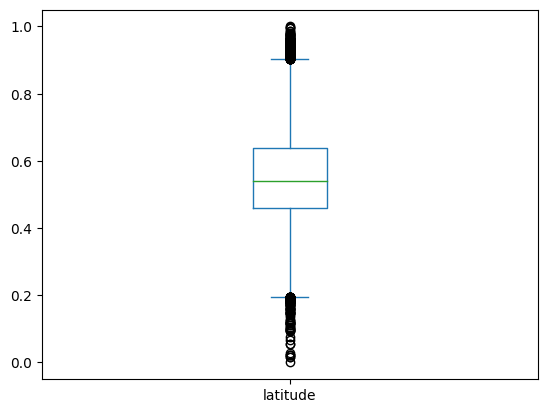

In [16]:
normalized_df['latitude'].plot.box()

<Axes: >

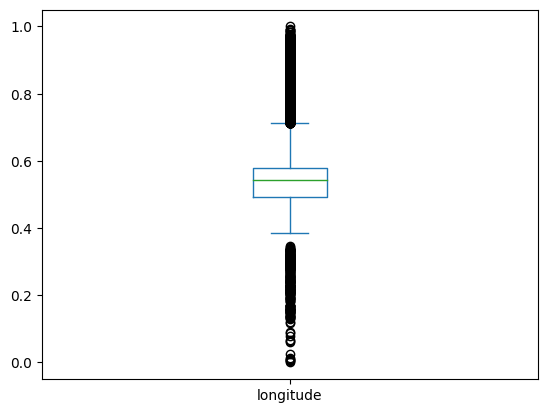

In [17]:
normalized_df['longitude'].plot.box()

<Axes: >

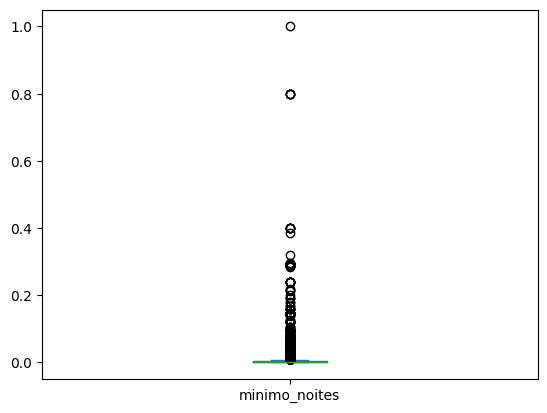

In [18]:
normalized_df['minimo_noites'].plot.box()

<Axes: >

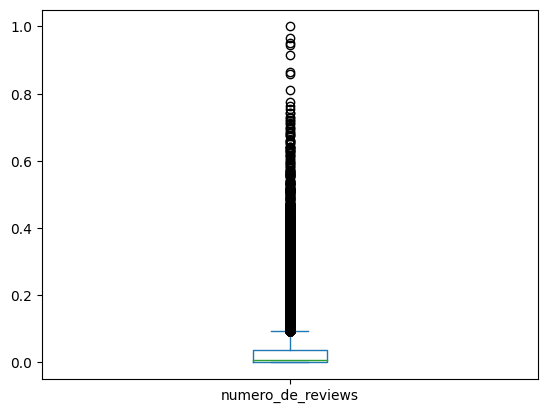

In [19]:
normalized_df['numero_de_reviews'].plot.box()

<Axes: >

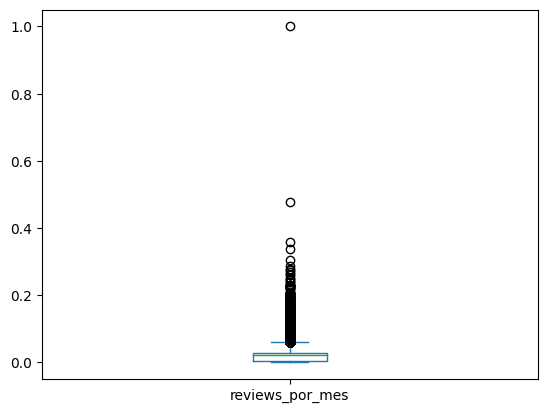

In [20]:
normalized_df['reviews_por_mes'].plot.box()

<Axes: >

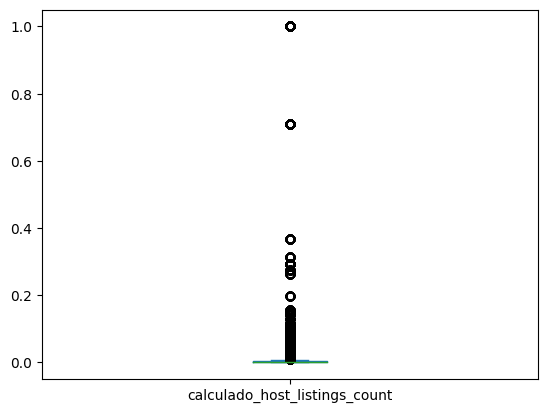

In [21]:
normalized_df['calculado_host_listings_count'].plot.box()

<Axes: >

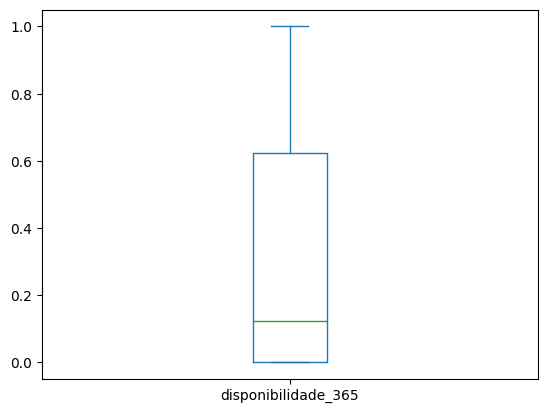

In [22]:
normalized_df['disponibilidade_365'].plot.box()

<Axes: >

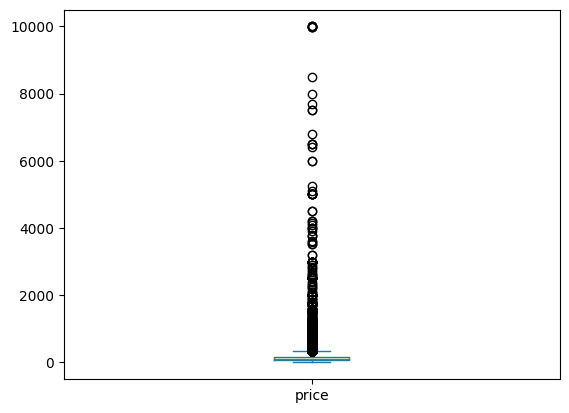

In [23]:
normalized_df['price'].plot.box()

Definição da função, baseada na metodologia Tukey para identificar os Outliers

In [ ]:
# Função para identificar outliers usando o método de Tukey
def identify_outliers_tukey(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

univar_outl_indices = set()

numeric_cols = ['price', 'latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

for col in numeric_cols:
    outliers_tukey = identify_outliers_tukey(normalized_df, col)

    if not outliers_tukey.empty:
        univar_outl_indices.update(outliers_tukey.index)

print(f"Em {len(univar_outl_indices)} linhas foram encontrados outliers.")

# Remover as linhas com outliers do DataFrame
df_cleaned = normalized_df.drop(index=univar_outl_indices)

print(f"Tamanho original do DataFrame: {df.shape[0]} linhas")
print(f"{100 - (100*df_cleaned.shape[0]/df.shape[0])}% das linhas possuem outliers e foram removidos")

Em 21127 linhas foram encontrados outliers.
Tamanho original do DataFrame: 48894 linhas
43.2098007935534% das linhas possuem outliers e foram removidos


Checagem dos BoxPlot após a remoção dos outliers

<Axes: >

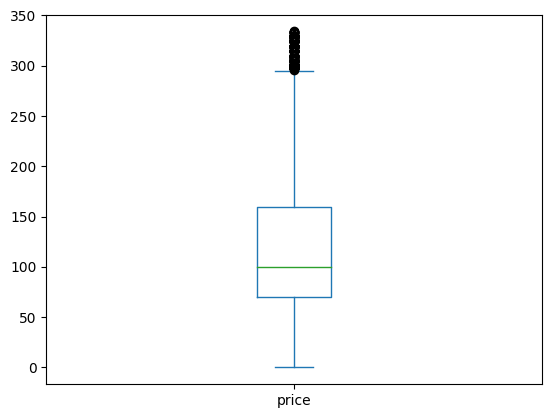

In [25]:
df_cleaned['price'].plot.box()

<Axes: >

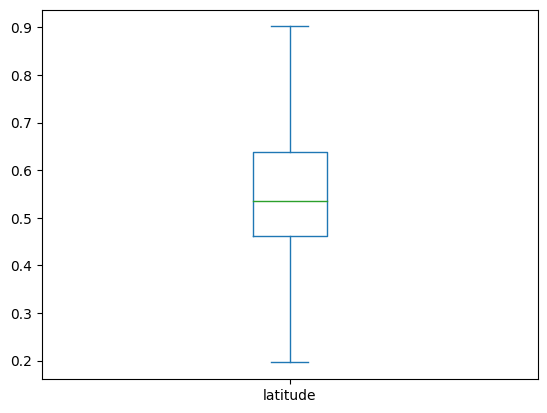

In [26]:
df_cleaned['latitude'].plot.box()

<Axes: >

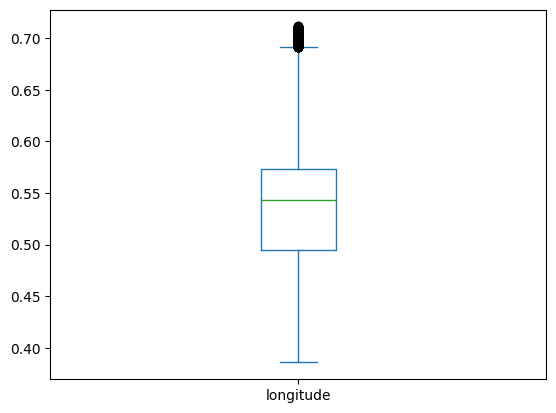

In [27]:
df_cleaned['longitude'].plot.box()

<Axes: >

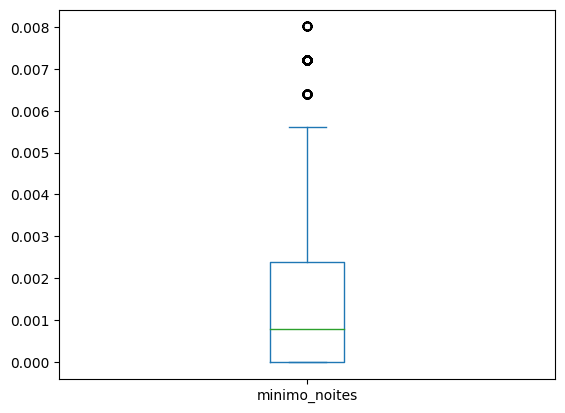

In [28]:
df_cleaned['minimo_noites'].plot.box()  

<Axes: >

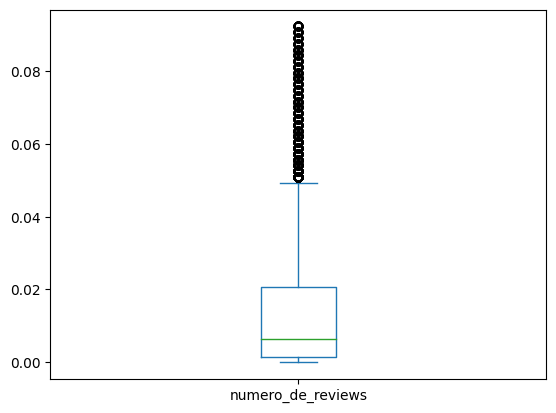

In [29]:
df_cleaned['numero_de_reviews'].plot.box()

<Axes: >

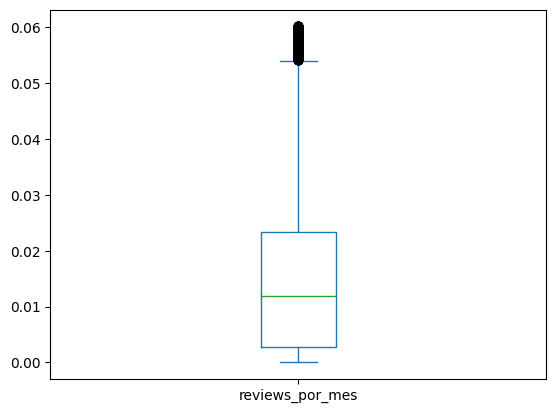

In [30]:
df_cleaned['reviews_por_mes'].plot.box()

<Axes: >

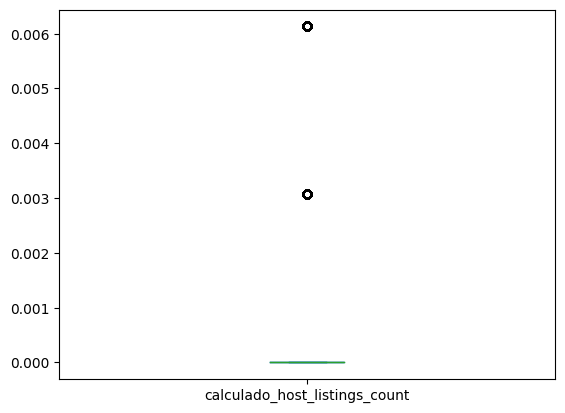

In [31]:
df_cleaned['calculado_host_listings_count'].plot.box()

<Axes: >

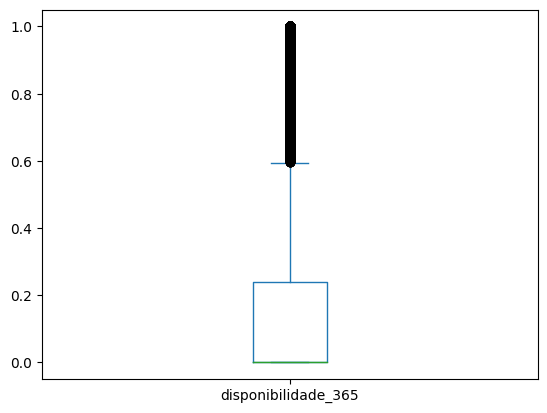

In [32]:
df_cleaned['disponibilidade_365'].plot.box()

### Análise descritiva

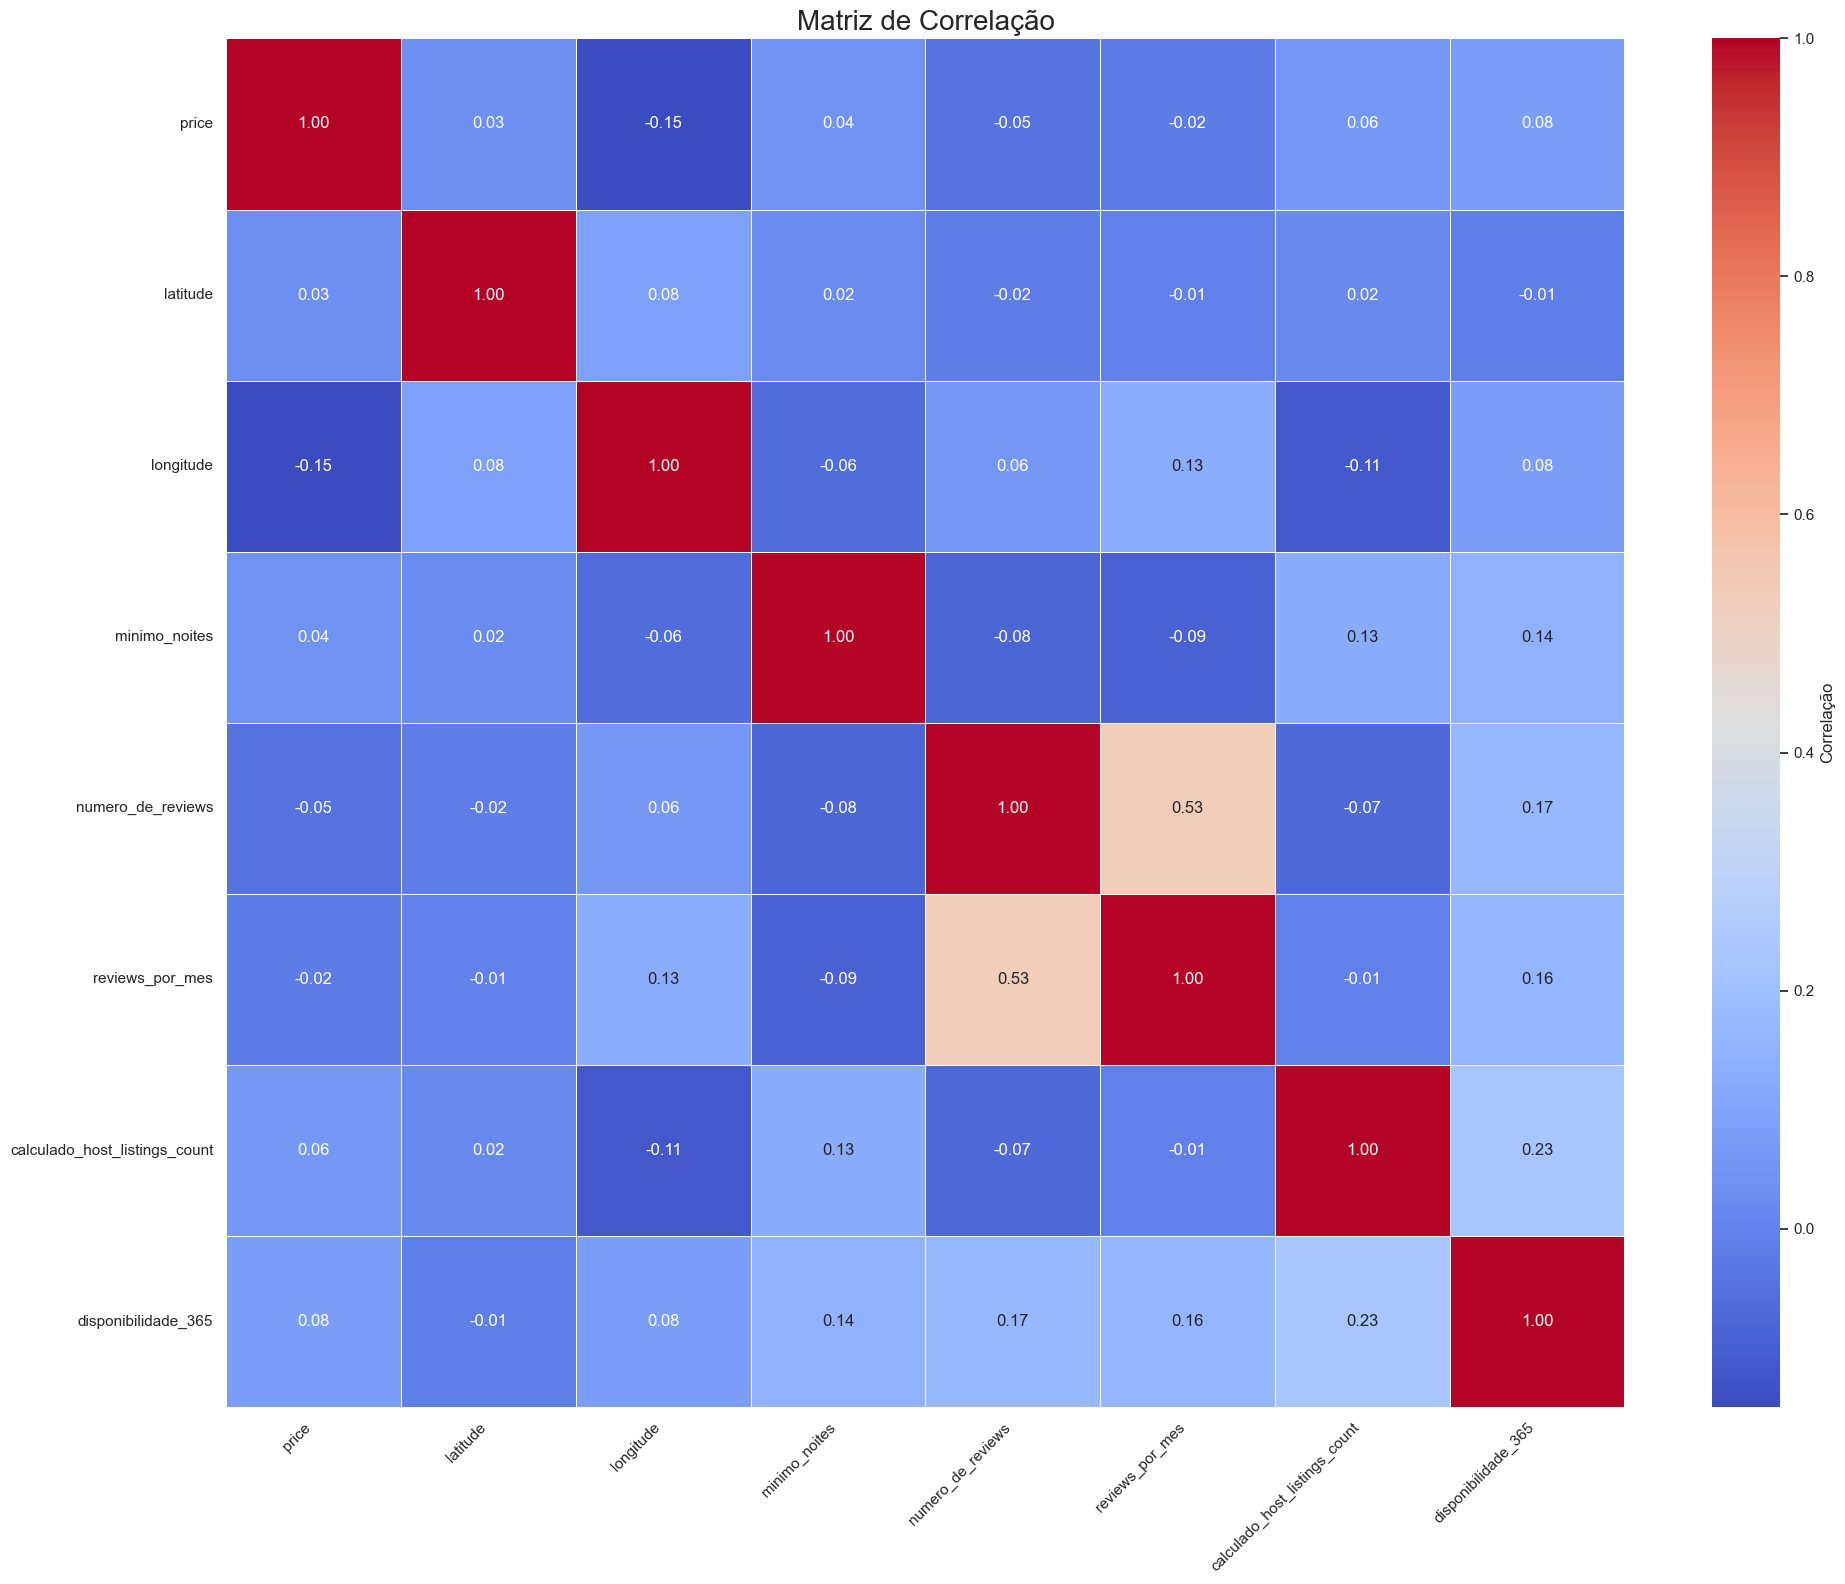

In [ ]:
correlation_matrix  = normalized_df[numeric_cols].corr(method='pearson')

sns.set(style='white')

# Criando uma figura maior
plt.figure(figsize=(20, 16))

# Criando o heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlação'}, linewidths=.5)

# Ajustando os rótulos dos eixos
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adicionando título
plt.title('Matriz de Correlação', size=20)

# Exibindo o heatmap
plt.tight_layout()
plt.show()

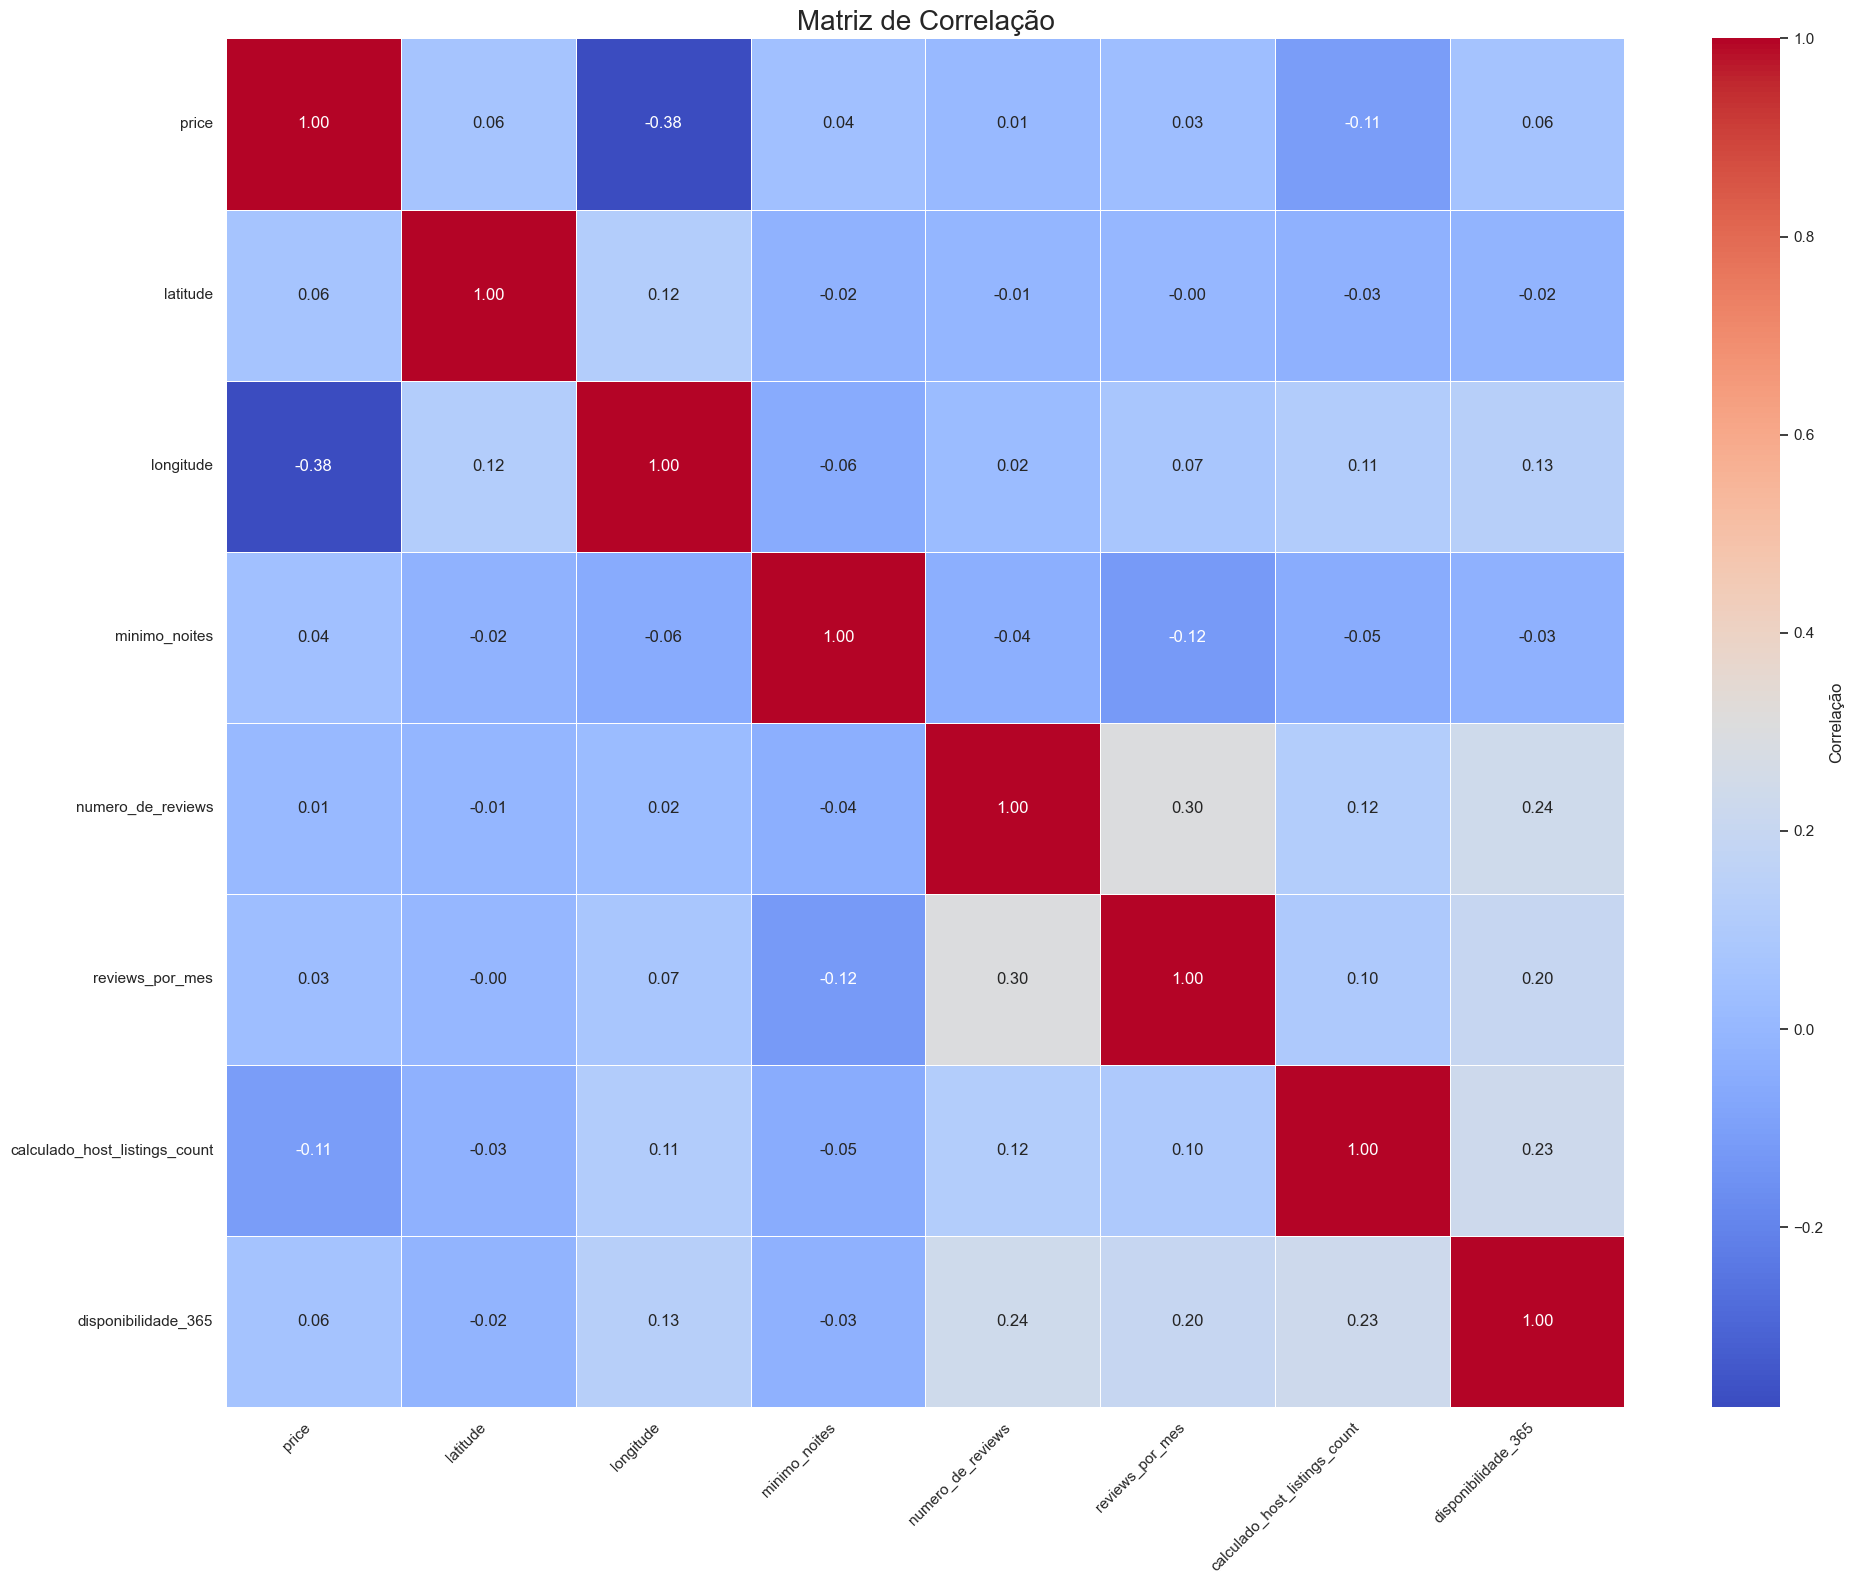

In [ ]:
correlation_matrix  = df_cleaned[numeric_cols].corr(method='pearson')

sns.set(style='white')

# Criando uma figura maior
plt.figure(figsize=(20, 16))

# Criando o heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlação'}, linewidths=.5)

# Ajustando os rótulos dos eixos
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adicionando título
plt.title('Matriz de Correlação', size=20)

# Exibindo o heatmap
plt.tight_layout()
plt.show()

Ao analisar as matrizes de correlação do dataset normalizado e do dataframe sem outliers, observa-se que as correlações entre as variáveis são, em geral, de baixa magnitude. Esse resultado indica uma fraca associação linear entre a maioria dos atributos, sugerindo que as variáveis analisadas não apresentam forte dependência entre si.

Dentre as correlações mais significativas, destaca-se a relação entre o número total de avaliações e a média de avaliações por mês. Essa forte correlação é esperada, dado que ambas as variáveis estão diretamente relacionadas à frequência de interações dos hóspedes com o anúncio ao longo do tempo. O número total de avaliações tende a aumentar proporcionalmente à taxa de avaliações mensais, especialmente em listagens ativas há mais tempo ou com alta demanda.

Agora foi feita avaliação sobre qual seria o melhor bairro para investir e colocar um imóvel para alugar na plataforma

In [35]:
df.sort_values(by='price', ascending=True).head(48870)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
25795,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
26865,21304320,Best Coliving space ever! Shared room.,101970559,Sergii,Brooklyn,Bushwick,40.69166,-73.90928,Shared room,0,30,5,2019-05-24,0.26,6,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45866,34981637,bay ridge & sunset park furnished apartment,263564234,Nony,Brooklyn,Bay Ridge,40.63087,-74.02006,Entire home/apt,4200,60,0,NaN,NaN,1,90
4375,2952861,Photography Location,1177497,Jessica,Brooklyn,Clinton Hill,40.69127,-73.96563,Entire home/apt,4500,1,5,2018-12-29,0.09,11,365
46613,35345358,Northside Williamsburg Stunner,956324,Alex,Brooklyn,Williamsburg,40.71705,-73.96470,Entire home/apt,4500,30,0,NaN,NaN,1,365
2697,1448703,Beautiful 1 Bedroom in Nolita/Soho,213266,Jessica,Manhattan,Nolita,40.72193,-73.99379,Entire home/apt,5000,1,2,2013-09-28,0.03,1,365


In [36]:
df2 = df.copy()

price_outliers = identify_outliers_tukey(df2, 'price')
df2 = df2.drop(index=price_outliers.index)

In [37]:
df2.sort_values(by='price', ascending=False).head(100)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
2157,995367,1BR Apt as featured in New York Mag,412783,Nick,Manhattan,Greenwich Village,40.73506,-73.99728,Entire home/apt,334,11,14,2018-05-29,0.24,1,238
43350,33607276,"Central Herald Sq.1BR w/ Roofdeck, Gym next to...",107434423,Blueground,Manhattan,Midtown,40.74875,-73.98675,Entire home/apt,334,30,0,NaN,NaN,232,311
38682,30387425,Swanky 1BR in Central Chelsea w/ Garden by Blu...,107434423,Blueground,Manhattan,Chelsea,40.73846,-73.99769,Entire home/apt,334,30,1,2019-04-15,0.35,232,310
38687,30387566,"Airy Times Sq 1BR w/ Indoor pool, Gym + Doorma...",107434423,Blueground,Manhattan,Theater District,40.76143,-73.98533,Entire home/apt,334,30,0,NaN,NaN,232,296
38781,30393759,Smart Studio in Heart of West Village w/ Doorm...,107434423,Blueground,Manhattan,West Village,40.73035,-74.00324,Entire home/apt,334,30,0,NaN,NaN,232,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17781,13951959,Newly Renovated Clinton Hill Duplex,66051630,Maya,Brooklyn,Clinton Hill,40.68265,-73.96631,Entire home/apt,325,5,80,2019-06-22,2.21,1,92
12802,9777504,Industrial Williamsburg Loft with Awesome Roof...,9424650,Anna,Brooklyn,Williamsburg,40.71761,-73.95423,Entire home/apt,325,3,74,2019-06-27,1.73,1,179
2124,975990,Brooklyn Heights Brownstone - Private Bdrm Avail.,5339881,Gerard,Brooklyn,Brooklyn Heights,40.69293,-73.99679,Entire home/apt,325,1,11,2018-12-09,0.19,1,363
6062,4438459,Gorgeous 1 Bedroom in the heart of NYC: Chelsea,4967319,Jessica,Manhattan,Chelsea,40.73974,-73.99985,Entire home/apt,325,2,19,2016-09-08,0.34,1,0


Top 10 Bairros nos Imóveis Mais Caros:
           bairro  quantidade
0      Manhattan          73
1       Brooklyn          24
2         Queens           3
3          Bronx           0
4  Staten Island           0


<Figure size 1000x600 with 0 Axes>

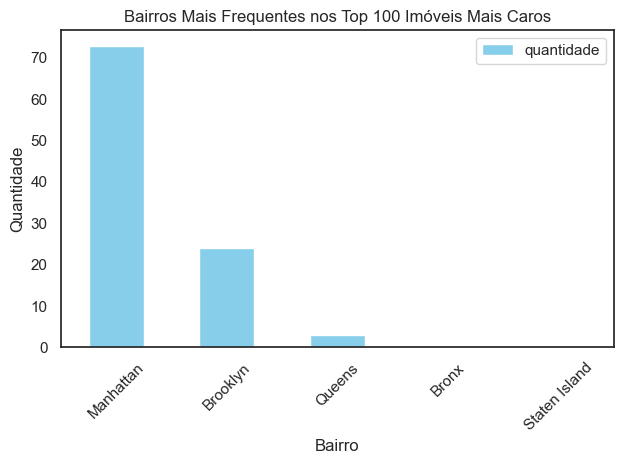

In [ ]:

top_100_caros = df2.sort_values(by='price', ascending=False).head(100)

bairros_mais_frequentes = top_100_caros['bairro_group'].value_counts().reset_index()
bairros_mais_frequentes.columns = ['bairro', 'quantidade']

print("Top 10 Bairros nos Imóveis Mais Caros:\n", bairros_mais_frequentes.head(10))

plt.figure(figsize=(10, 6))
bairros_mais_frequentes.head(10).plot(kind='bar', x='bairro', y='quantidade', color='skyblue')
plt.title('Bairros Mais Frequentes nos Top 100 Imóveis Mais Caros')
plt.xlabel('Bairro')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
df2.groupby('bairro_group', observed=False)['price'].median().sort_values(ascending=False)

bairro_group
Manhattan        135.0
Brooklyn          90.0
Staten Island     75.0
Queens            74.0
Bronx             65.0
Name: price, dtype: float64

Analisando tais gráficos percebe-se que o melhor lugar para investir é em Manhattan visto que é o bairro que mais aparece entre os aluguéis mais caros e pelo fato de possuir a maior mediana entre os bairros

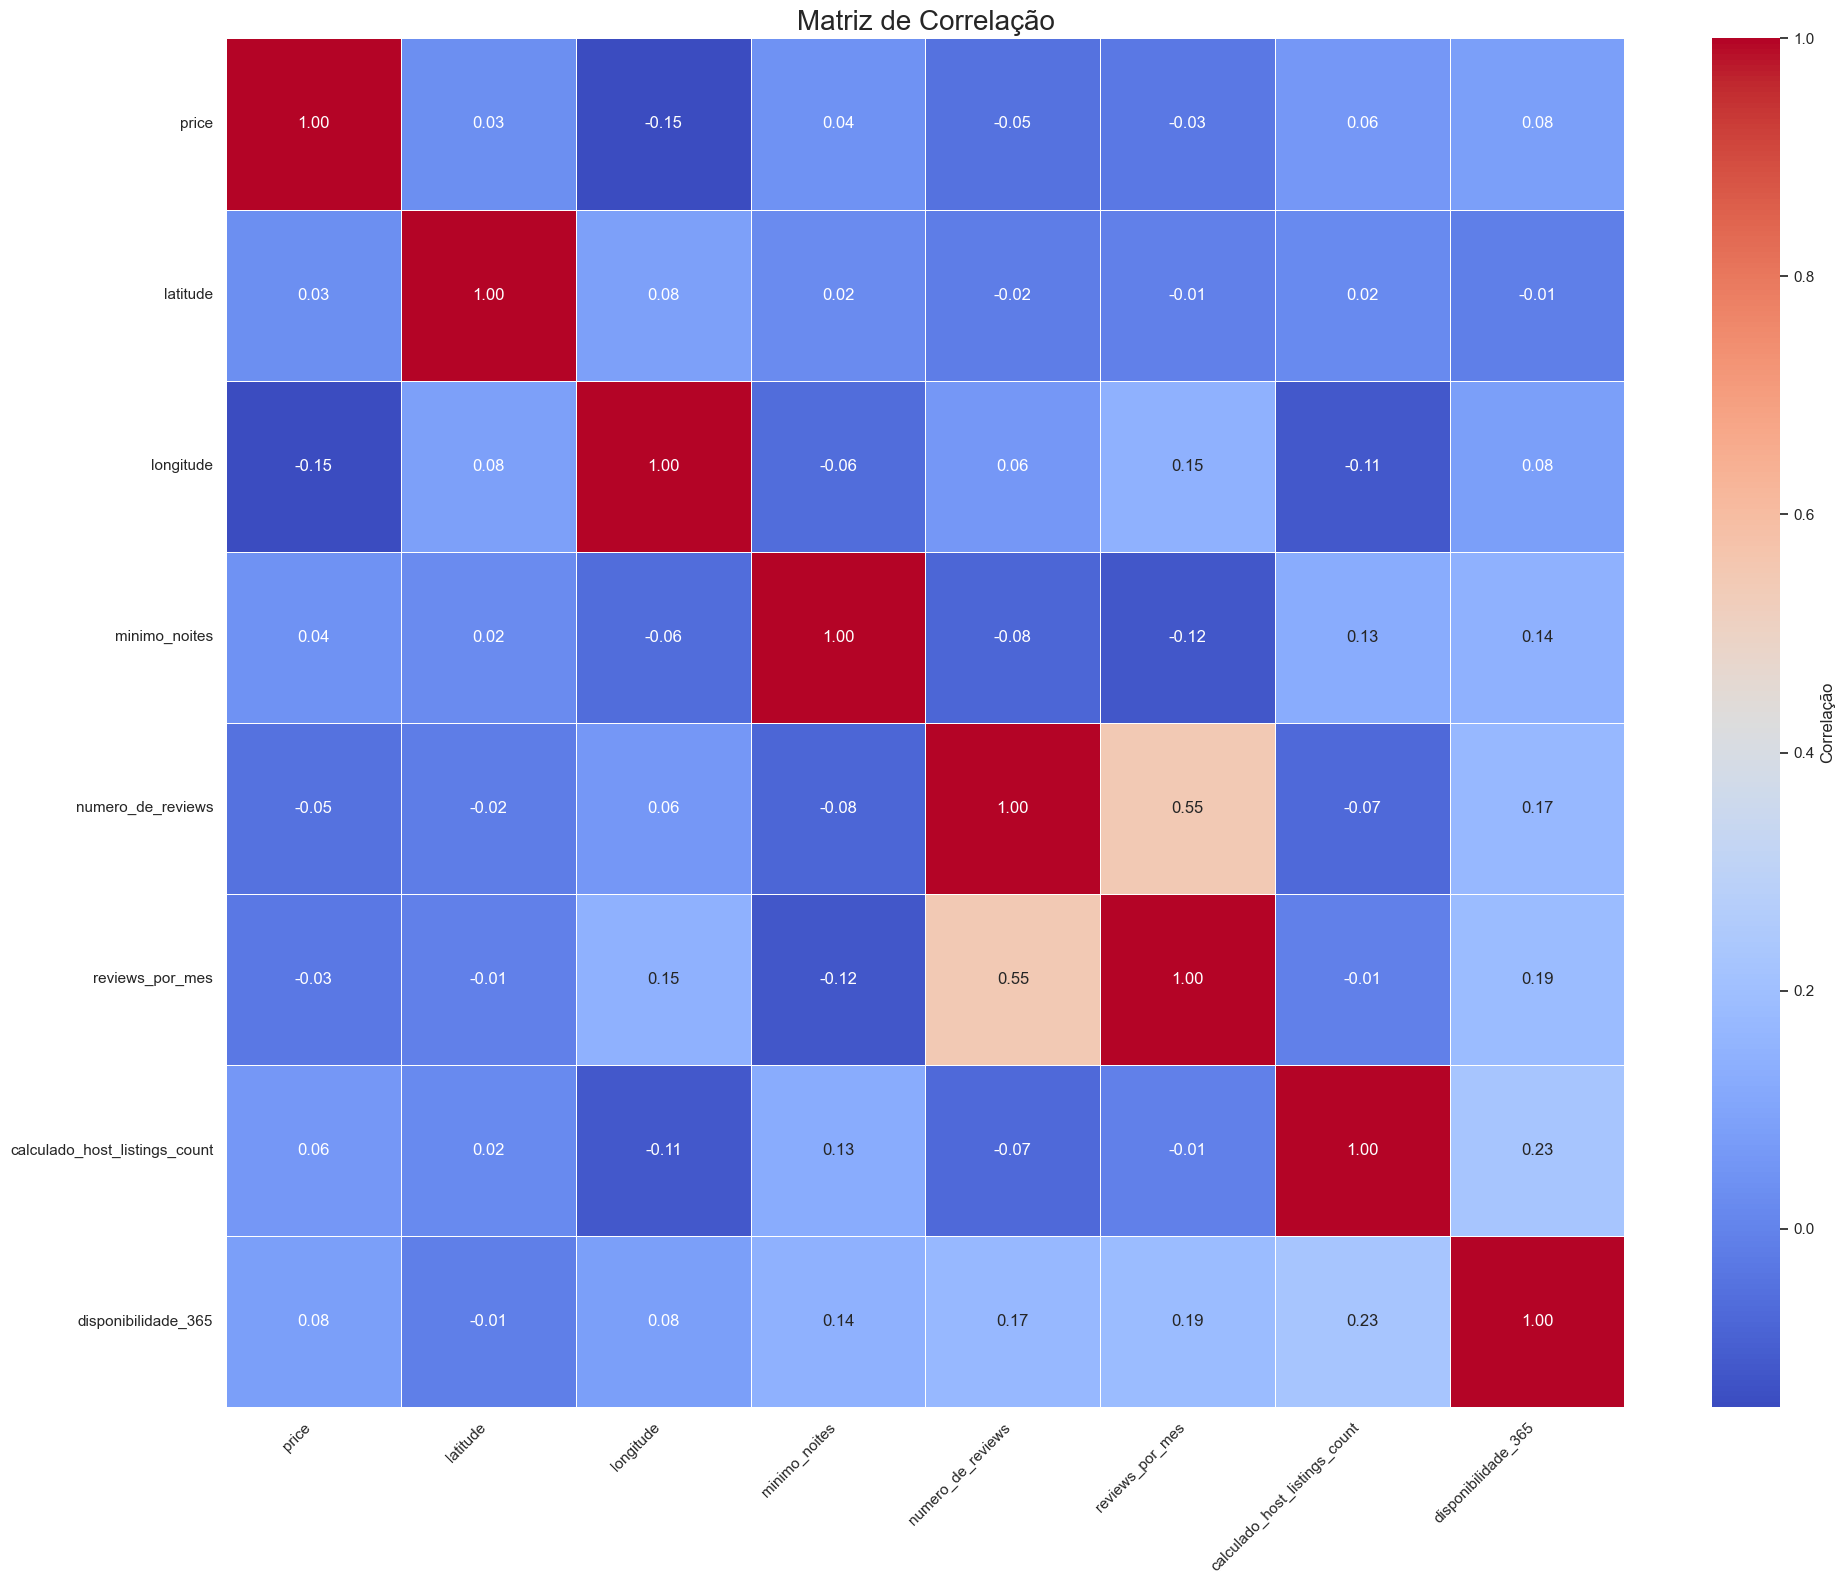

In [ ]:

correlation_matrix  = df[numeric_cols].corr(method='pearson')

sns.set(style='white')

# Criando uma figura maior
plt.figure(figsize=(20, 16))

# Criando o heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlação'}, linewidths=.5)

# Ajustando os rótulos dos eixos
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adicionando título
plt.title('Matriz de Correlação', size=20)

# Exibindo o heatmap
plt.tight_layout()
plt.show()

Revendo a matriz de correlação nota-se que o número minimo de noites e disponibilidade 365 não interfere no preço, pelo fato da correlação entre essas variáveis ser correlação muito baixa, 0.08 e 0.04 respectivamente

In [41]:
df2.sort_values(by='price', ascending=False).head(1000)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
2157,995367,1BR Apt as featured in New York Mag,412783,Nick,Manhattan,Greenwich Village,40.73506,-73.99728,Entire home/apt,334,11,14,2018-05-29,0.24,1,238
43350,33607276,"Central Herald Sq.1BR w/ Roofdeck, Gym next to...",107434423,Blueground,Manhattan,Midtown,40.74875,-73.98675,Entire home/apt,334,30,0,NaN,NaN,232,311
38682,30387425,Swanky 1BR in Central Chelsea w/ Garden by Blu...,107434423,Blueground,Manhattan,Chelsea,40.73846,-73.99769,Entire home/apt,334,30,1,2019-04-15,0.35,232,310
38687,30387566,"Airy Times Sq 1BR w/ Indoor pool, Gym + Doorma...",107434423,Blueground,Manhattan,Theater District,40.76143,-73.98533,Entire home/apt,334,30,0,NaN,NaN,232,296
38781,30393759,Smart Studio in Heart of West Village w/ Doorm...,107434423,Blueground,Manhattan,West Village,40.73035,-74.00324,Entire home/apt,334,30,0,NaN,NaN,232,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28458,22079387,Boutique Luxury in the Heart of Chelsea,148107543,Mario,Manhattan,Chelsea,40.74494,-73.99762,Entire home/apt,299,2,30,2019-05-25,1.57,1,274
38489,30290307,Beautiful Central 2 Bedroom in Soho!,227498924,Alex,Manhattan,SoHo,40.72607,-74.00166,Entire home/apt,299,4,2,2019-05-18,0.32,1,156
3483,2085632,Private Deck 2 Bedroom+2 Bath East Village,10650502,Jeni,Manhattan,East Village,40.72247,-73.97923,Entire home/apt,299,28,92,2018-07-25,1.37,1,14
47794,35916913,New Massive 4BR/3.5BA Townhouse near Park Ave,144813834,Dominic,Manhattan,Upper East Side,40.76090,-73.96147,Entire home/apt,299,3,0,NaN,NaN,1,177


Sobre os nomes dos locais mais caros dá para notar que eles são mais formais, para chamar atenção de pessoas mais rebuscadas

### Hipóteses

Hipótese Nula(H0): Não há diferença de preços entre os bairros

Hipótese Alternativa(H1): Há diferença de preços entre os bairros

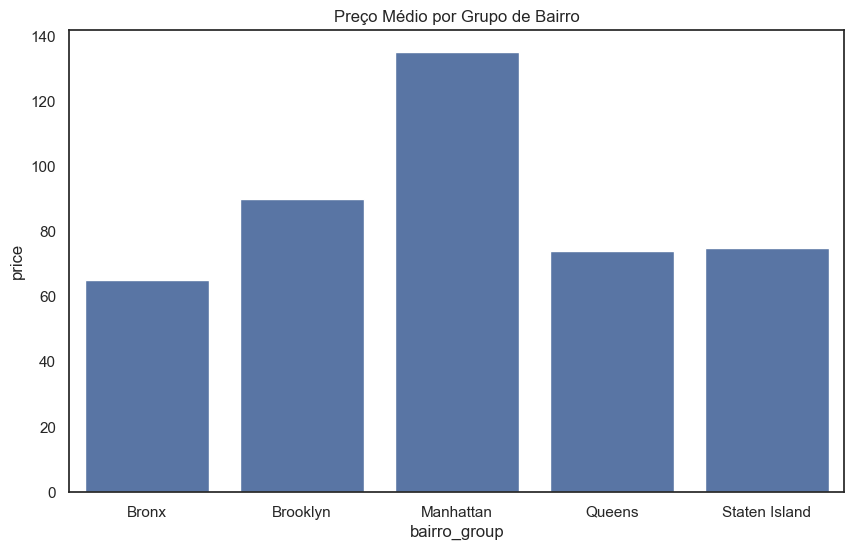

F_onewayResult(statistic=911.4974624959116, pvalue=0.0)

In [ ]:
# Média de preço por bairro_group
plt.figure(figsize=(10, 6))
sns.barplot(x='bairro_group', y='price', data=df2, estimator='median', errorbar=None)
plt.title('Preço Médio por Grupo de Bairro')
plt.show()

# Teste ANOVA
groups = [df_cleaned[df_cleaned['bairro_group'] == grupo]['price'] for grupo in df_cleaned['bairro_group'].unique()]
f_oneway(*groups)

pvalue muito baixo significa que a hipótese nula foi negada

In [ ]:
tukey = pairwise_tukeyhsd(
    endog=df2['price'],   # Variável target
    groups=df2['bairro_group'],  # Grupos (bairros)
    alpha=0.05  # Nível de significância
)
print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj  lower    upper   reject
---------------------------------------------------------------
    Bronx      Brooklyn   28.332   0.0  22.8435  33.8204   True
    Bronx     Manhattan  68.5874   0.0  63.0996  74.0752   True
    Bronx        Queens   11.539   0.0   5.7049  17.3731   True
    Bronx Staten Island  11.8702 0.019   1.2757  22.4647   True
 Brooklyn     Manhattan  40.2555   0.0  38.4836  42.0273   True
 Brooklyn        Queens -16.7929   0.0 -19.4502 -14.1357   True
 Brooklyn Staten Island -16.4618   0.0 -25.6958  -7.2277   True
Manhattan        Queens -57.0484   0.0 -59.7042 -54.3926   True
Manhattan Staten Island -56.7172   0.0 -65.9508 -47.4836   True
   Queens Staten Island   0.3312   1.0  -9.1124   9.7747  False
---------------------------------------------------------------


Fazendo essa outra análise estatística percebe-se que a comparação entre os bairros Queens e Staten Island segue a hipótese nula e possuem preços médios semelhantes

Hipótese Nula(H0): Imóveis de room_type distintos tem a mesma média de preço

Hipótese Alternativa(H1): Imóveis de room_type distintos tem média de preço diferentes

Estatística F: 8384.69587714965, p-valor: 0.0


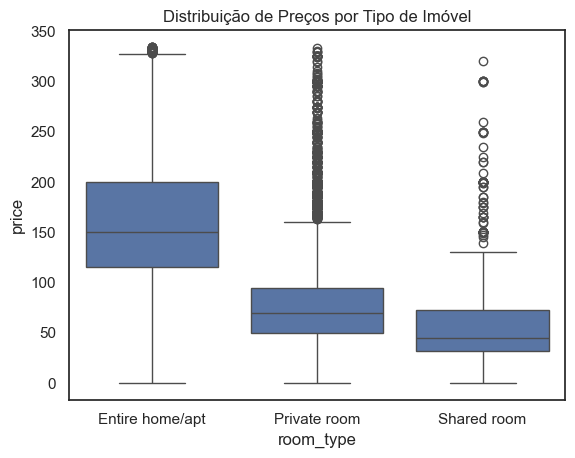

In [46]:
from scipy.stats import f_oneway
import seaborn as sns

# Teste ANOVA
groups = [df_cleaned[df_cleaned['room_type'] == tipo]['price'] for tipo in df_cleaned['room_type'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"Estatística F: {f_stat}, p-valor: {p_value}")

# Boxplot para visualização
sns.boxplot(x='room_type', y='price', data=df2)
plt.title('Distribuição de Preços por Tipo de Imóvel')
plt.show()

A hipótese nula é negada visto que pvalue é 0

In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(df2['price'], df2['room_type'], alpha=0.05)
print(tukey.summary())

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1        group2     meandiff p-adj  lower    upper   reject
---------------------------------------------------------------------
Entire home/apt Private room  -83.5118   0.0 -84.6947 -82.3288   True
Entire home/apt  Shared room -103.2336   0.0 -107.035 -99.4322   True
   Private room  Shared room  -19.7218   0.0 -23.5265 -15.9172   True
---------------------------------------------------------------------


Essa outra análise mostra que não há exceção para essa hipótese

### Dados para a predição

df_cleaned: Dados sem outliers, sem valores faltantes e com apenas colunas numéricas

df2: Mantém as colunas categóricas, com valores faltantes e apenas sem outliers relacionados a coluna 'price'

In [52]:
df_cleaned.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,37454.0,2845,4785.0,2,127,0.614199,0.490469,0,225,0.000000,0.071542,1715.000000,0.006326,0.003067,0.972603
1,3647,43542.0,4632,2909.0,2,94,0.748252,0.569257,1,150,0.001601,0.000000,1490.095695,0.023307,0.000000,1.000000
3,5022,18692.0,7192,5923.0,2,61,0.722820,0.565324,0,80,0.007206,0.014308,1532.000000,0.001539,0.000000,0.000000
9,5295,5507.0,7702,6024.0,2,202,0.734072,0.524942,0,135,0.003203,0.084261,1747.000000,0.007181,0.000000,0.016438
18,7750,22627.0,17985,9701.0,2,61,0.718804,0.556423,0,190,0.004804,0.000000,1490.095695,0.023307,0.003067,0.682192


In [53]:
df2.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [54]:
df2.dtypes

id                                  int64
nome                             category
host_id                             int64
host_name                        category
bairro_group                     category
bairro                           category
latitude                          float64
longitude                         float64
room_type                        category
price                               int64
minimo_noites                       int64
numero_de_reviews                   int64
ultima_review                    category
reviews_por_mes                   float64
calculado_host_listings_count       int64
disponibilidade_365                 int64
dtype: object

Remoção de colunas desnecessárias para a predição do df2, são colunas de alta cardinalidade e que não afetaria no preço do imóvel

In [55]:
df2_predictions = df2.copy()

df2_predictions.drop(columns=['id', 'nome', 'host_id', 'host_name', 'ultima_review'], inplace=True)

Remoção de nulos e codificação das colunas categóricas restantes

In [56]:
df2_predictions_no_na = df2_predictions.dropna()

In [57]:
df2_predictions_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36910 entries, 0 to 48851
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   bairro_group                   36910 non-null  category
 1   bairro                         36910 non-null  category
 2   latitude                       36910 non-null  float64 
 3   longitude                      36910 non-null  float64 
 4   room_type                      36910 non-null  category
 5   price                          36910 non-null  int64   
 6   minimo_noites                  36910 non-null  int64   
 7   numero_de_reviews              36910 non-null  int64   
 8   reviews_por_mes                36910 non-null  float64 
 9   calculado_host_listings_count  36910 non-null  int64   
 10  disponibilidade_365            36910 non-null  int64   
dtypes: category(3), float64(3), int64(5)
memory usage: 2.7 MB


In [58]:
df2_predictions_no_na['bairro_group'] = df2_predictions_no_na['bairro_group'].cat.codes
df2_predictions_no_na['bairro'] = df2_predictions_no_na['bairro'].cat.codes
df2_predictions_no_na['room_type'] = df2_predictions_no_na['room_type'].cat.codes

C:\Users\caiop\AppData\Local\Temp\ipykernel_16260\3539964063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_predictions_no_na['bairro_group'] = df2_predictions_no_na['bairro_group'].cat.codes
C:\Users\caiop\AppData\Local\Temp\ipykernel_16260\3539964063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_predictions_no_na['bairro'] = df2_predictions_no_na['bairro'].cat.codes
C:\Users\caiop\AppData\Local\Temp\ipykernel_16260\3539964063.py:3: SettingWithCopyWarning: 
A value is trying to be set on

In [59]:
df2_predictions_no_na.head()

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2,127,40.75362,-73.98377,0,225,1,45,0.38,2,355
2,1,41,40.68514,-73.95976,0,89,1,270,4.64,1,194
3,2,61,40.79851,-73.94399,0,80,10,9,0.10,1,0
4,2,137,40.74767,-73.97500,0,200,3,74,0.59,1,129
5,1,13,40.68688,-73.95596,1,60,45,49,0.40,1,0


### Predição

In [69]:
X = df2_predictions_no_na.drop(columns=['price'])
y = df2_predictions_no_na['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
}

model = xgb.XGBRegressor(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 1793.15
MAE: 30.10
MSE: 1904.08
MAE: 31.49


In [76]:
# Salvar o modelo
with open('best_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [61]:
df_predictions = df_cleaned.copy()

df_predictions.drop(columns=['id', 'nome', 'host_id', 'host_name'], inplace=True)

df_predictions.head()

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2,127,0.614199,0.490469,0,225,0.000000,0.071542,1715.000000,0.006326,0.003067,0.972603
1,2,94,0.748252,0.569257,1,150,0.001601,0.000000,1490.095695,0.023307,0.000000,1.000000
3,2,61,0.722820,0.565324,0,80,0.007206,0.014308,1532.000000,0.001539,0.000000,0.000000
9,2,202,0.734072,0.524942,0,135,0.003203,0.084261,1747.000000,0.007181,0.000000,0.016438
18,2,61,0.718804,0.556423,0,190,0.004804,0.000000,1490.095695,0.023307,0.003067,0.682192


In [ ]:
X = df_predictions.drop(columns=['price'])
y = df_predictions['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)

print(f"MSE val: {mse:.2f}")

r2 = r2_score(y_val, y_pred)

print(f"R² val: {r2:.2f}")

mae = mean_absolute_error(y_val, y_pred)

print(f"MAE val: {mae:.2f}")

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"MSE test: {mse:.2f}")

r2 = r2_score(y_test, y_pred)

print(f"R² test: {r2:.2f}")

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE test: {mae:.2f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 3, 'n_estimators': 100}
MSE val: 1931.62
R² val: 0.57
MAE val: 32.57
MSE test: 2041.84
R² test: 0.55
MAE test: 33.18


In [ ]:
rf_model = RandomForestRegressor(random_state=42)  

param_grid = {  
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}       

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)

print(f"MSE val: {mse:.2f}")

r2 = r2_score(y_val, y_pred)

print(f"R² val: {r2:.2f}")

mae = mean_absolute_error(y_val, y_pred)

print(f"MAE val: {mae:.2f}")

y_pred = best_model.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)

print(f"MSE test: {mse:.2f}")

r2 = r2_score(y_test, y_pred)

print(f"R² test: {r2:.2f}")

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE test: {mae:.2f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 5, 'n_estimators': 300}
MSE val: 2074.81
R² val: 0.53
MAE val: 33.85
MSE test: 2177.87
R² test: 0.52
MAE test: 34.51


In [64]:
df_cleaned['price'].median()

100.0

# Previsão do Preço: Explicação do Modelo

## 1. Como realizar a previsão do preço a partir dos dados?
Para prever o preço (`price`), foi utilizada uma abordagem de aprendizado supervisionado de regressão com o modelo **XGBoost Regressor**. As variáveis independentes (features) utilizadas foram:

- **Variáveis categóricas transformadas em codificações numéricas**:
  - `bairro_group`, `bairro` e `room_type` foram convertidas usando o atributo `.cat.codes`, tornando-as adequadas para modelos baseados em árvores.

- **Variáveis numéricas contínuas**:
  - `latitude` e `longitude`: representam a localização do imóvel e podem capturar diferenças regionais nos preços.
  - `minimo_noites` (mínimo de noites de reserva).
  - `numero_de_reviews` (número total de avaliações).
  - `reviews_por_mes` (avaliações médias por mês).
  - `calculado_host_listings_count` (quantidade de anúncios ativos do anfitrião).
  - `disponibilidade_365` (dias disponíveis no ano para reservas).

Essas variáveis foram escolhidas por sua relação direta com os fatores que influenciam o preço, como localização, demanda e características do imóvel.

---

## 2. Transformações realizadas e justificativas
- **Remoção de colunas desnecessárias**: Colunas como `id`, `nome`, `host_id` e `host_name` foram excluídas, pois possuem alta cardinalidade ou não contribuem diretamente para a previsão do preço.
- **Remoção de valores nulos**: As observações com valores ausentes foram eliminadas para evitar inconsistências durante o treinamento.
- **Codificação de variáveis categóricas**: Transformar categorias em valores numéricos foi essencial para que o modelo baseado em árvores pudesse processá-las corretamente.
- **Remoção de outliers do preço**: Foram removidos todos os outliers dessa coluna para evitar confusão do modelo com comparações irreais relacionadas ao padrão do dataframe

---

## 3. Tipo de problema
O problema é de **regressão**, pois o objetivo é prever um valor contínuo (o preço por noite em dólares).

---

## 4. Modelo utilizado e análise de desempenho
O modelo escolhido foi o **XGBoost Regressor**, que é um algoritmo baseado em gradient boosting. Ele foi selecionado devido à sua alta performance em problemas de regressão e capacidade de lidar com:
- Dados não linearmente distribuídos.
- Variáveis categóricas e numéricas.
- Presença de colinearidade parcial.

### **Prós do XGBoost**:
- Ótima capacidade de generalização com ajuste adequado de hiperparâmetros.
- Alta velocidade de treinamento e eficiência computacional.
- Capacidade de lidar com outliers moderados e valores ausentes (se configurado para isso).

### **Contras do XGBoost**:
- Pode ser sensível ao overfitting, especialmente em datasets pequenos.
- Requer ajustes finos de hiperparâmetros para obter o melhor desempenho.

---

## 5. Métrica de avaliação utilizada
As métricas utilizadas foram:
- **MSE (Mean Squared Error)**: Avalia o erro quadrático médio entre os valores reais e preditos. Foi escolhida por penalizar erros maiores, o que é útil para destacar discrepâncias significativas.
- **MAE (Mean Absolute Error)**: Mede o erro absoluto médio, sendo mais intuitiva para interpretação, pois está na mesma escala do preço (em dólares).

### **Justificativa para usar MSE e MAE**:
- O MSE foi usado como métrica principal no treinamento do modelo, pois é mais sensível a grandes desvios (valores outliers) e orienta melhor o ajuste do modelo.
- O MAE foi calculado como complemento para fornecer uma visão prática da média de erro, tornando a interpretação mais direta.

---

## 6. Resultados obtidos
- **Validação**: MSE = 1793.15 e MAE = 30.10.
- **Teste**: MSE = 1904.08 e MAE = 31.49.

Esses valores indicam que o modelo é capaz de prever o preço por noite com um erro absoluto médio de aproximadamente 30 dólares, o que é razoável dependendo da faixa de preço predominante no dataset.

---

## Conclusão
O modelo utiliza as variáveis preditoras relacionadas à localização, características do imóvel e demanda, aplicando transformações adequadas para torná-las utilizáveis por algoritmos de aprendizado de máquina. O XGBoost foi escolhido por sua eficiência e desempenho em problemas de regressão. As métricas MSE e MAE foram selecionadas para avaliar a qualidade das previsões, com foco em balancear sensibilidade a grandes erros (MSE) e interpretação prática (MAE).


Modelo que obteve os melhores resultado: Xgboost usando o dataframe df2_predictions_no_na

In [77]:
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

Predição solicitada no teste

In [78]:
predict_set = pd.DataFrame({'id': [2595],
 'nome': ['Skylit Midtown Castle'],
 'host_id': [2845],
 'host_name': ['Jennifer'],
 'bairro_group': ['Manhattan'],
 'bairro': ['Midtown'],
 'latitude': [40.75362],
 'longitude': [-73.98377],
 'room_type': ['Entire home/apt'],
 'minimo_noites': [1],
 'numero_de_reviews': [45],
 'ultima_review': ['2019-05-21'],
 'reviews_por_mes': [0.38],
 'calculado_host_listings_count': [2],
 'disponibilidade_365': [355]
})

predict_set.drop(columns=['id', 'nome', 'host_id', 'host_name', 'ultima_review'], inplace=True)

predict_set.info()

predict_set['bairro_group'] = predict_set['bairro_group'].astype('category')
predict_set['bairro'] = predict_set['bairro'].astype('category')
predict_set['room_type'] = predict_set['room_type'].astype('category')

predict_set['bairro_group'] = predict_set['bairro_group'].cat.codes
predict_set['bairro'] = predict_set['bairro'].cat.codes
predict_set['room_type'] = predict_set['room_type'].cat.codes

price_prediction = best_model.predict(predict_set)
price_prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bairro_group                   1 non-null      object 
 1   bairro                         1 non-null      object 
 2   latitude                       1 non-null      float64
 3   longitude                      1 non-null      float64
 4   room_type                      1 non-null      object 
 5   minimo_noites                  1 non-null      int64  
 6   numero_de_reviews              1 non-null      int64  
 7   reviews_por_mes                1 non-null      float64
 8   calculado_host_listings_count  1 non-null      int64  
 9   disponibilidade_365            1 non-null      int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 212.0+ bytes


array([237.81557], dtype=float32)